# Setting up to run the model on Google Colab 

- Download dataset to Google Drive. Specifically, “MyDrive/data”. Keep the files zipped to save space on your dive (and because our code unzips the files as necessary)
	- Alternatively, download the zip files to a folder of your choice and change the path in the code
	  ``zip_files_path = '/content/drive/MyDrive/YOUR_PATH_HERE/'`` to the path that contains the dataset
- You can either run each code block individually or go to the top of Google Colab and select Runtime->Run all (ctrl+F9).
  - In the beginning few code blocks, it will ask to connect to your google drive. So if you run all the code at once, don't walk away right a way. Follow the prompts to allow Google Colab to connect to your Google Drive.
- Once that's done, the whole code takes around 1.5-2hrs to fully run using the T4 GPU on Google Colab Pro.
# Setting up to run the model on your Windows Machine
- Open Visual Studio Code (VSC)
- Install the Jupyter extension to VSC https://marketplace.visualstudio.com/items?itemName=ms-toolsai.jupyter
  It should also install Jupyter Cell Tags https://marketplace.visualstudio.com/items?itemName=ms-toolsai.vscode-jupyter-cell-tags and Jupyter Keymap extensions https://marketplace.visualstudio.com/items?itemName=ms-toolsai.jupyter-keymap
- Install Python 3.4 as a min, newer the version the better https://www.python.org/downloads/
	- Microsoft may also require you to install python 3 from the Microsoft store (I had to even after changing the PATH environment variables) https://medium.com/@viknesh2798/how-to-fix-the-issues-while-using-python-command-in-the-command-prompt-ba56d9018c5f
	- If pip is not installed follow the instructions in this link to install pip https://www.geeksforgeeks.org/how-to-install-pip-on-windows/
- open command prompt and run ``pip install qtpy tensorflow opencv-python matplotlib pillow seaborn scikit-learn keras-tuner ipykernel``
- Once that's done, go back to VSC and change 2 lines of code to match the below (in 3. Extract Data files to local machine and unzip)
```python
  # Path to the folder containing the zip files in Google Drive
  # zip_files_path = '/content/drive/MyDrive/data/'
  # Path to the folder containing the zip file on local machine
  zip_files_path = 'data'
```

- Finally runn all cells in order excpet "2. Mount Data from Google Drive"
	- Alternatively comment out all of section 2 and press the "Run All" button at the top.

# 1. Install Dependencies and Setup

In [1]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib
!pip list
import tensorflow as tf
import os
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices('GPU')

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.3
aiosignal                        1.3.1
alabaster                        0.7.16
albumentations                   1.3.1
altair                           4.2.2
annotated-types                  0.6.0
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings       

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2. Mount Data from Google Drive

In [2]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# 3. Extract Data files to local machine and unzip

In [3]:
import zipfile
import os
import shutil

# Path to the folder containing the zip files in Google Drive
zip_files_path = '/content/drive/MyDrive/data/'
# Path to the folder containing the zip file on local machine
# zip_files_path = 'data'

# Path where you want to extract the datasets in Colab
extract_to_path = 'content/dataset/'

os.makedirs(extract_to_path, exist_ok=True)

# Loop through each zip file and extract it
for zip_file in os.listdir(zip_files_path):
    if zip_file.endswith('.zip'):
        with zipfile.ZipFile(os.path.join(zip_files_path, zip_file), 'r') as zip_ref:
            zip_ref.extractall(extract_to_path)

print("Extraction completed.")


Extraction completed.


# 4. Remove unnessary _MACOSX folder

In [4]:
# Path to the _MACOSX folder
macosx_path = os.path.join(extract_to_path, '__MACOSX')

# Check if the folder exists, and if so, remove it
if os.path.exists(macosx_path):
    shutil.rmtree(macosx_path)
    print("__MACOSX folder removed successfully.")
else:
    print("__MACOSX folder does not exist or was already removed.")

__MACOSX folder removed successfully.


# 5. Data Visulaization

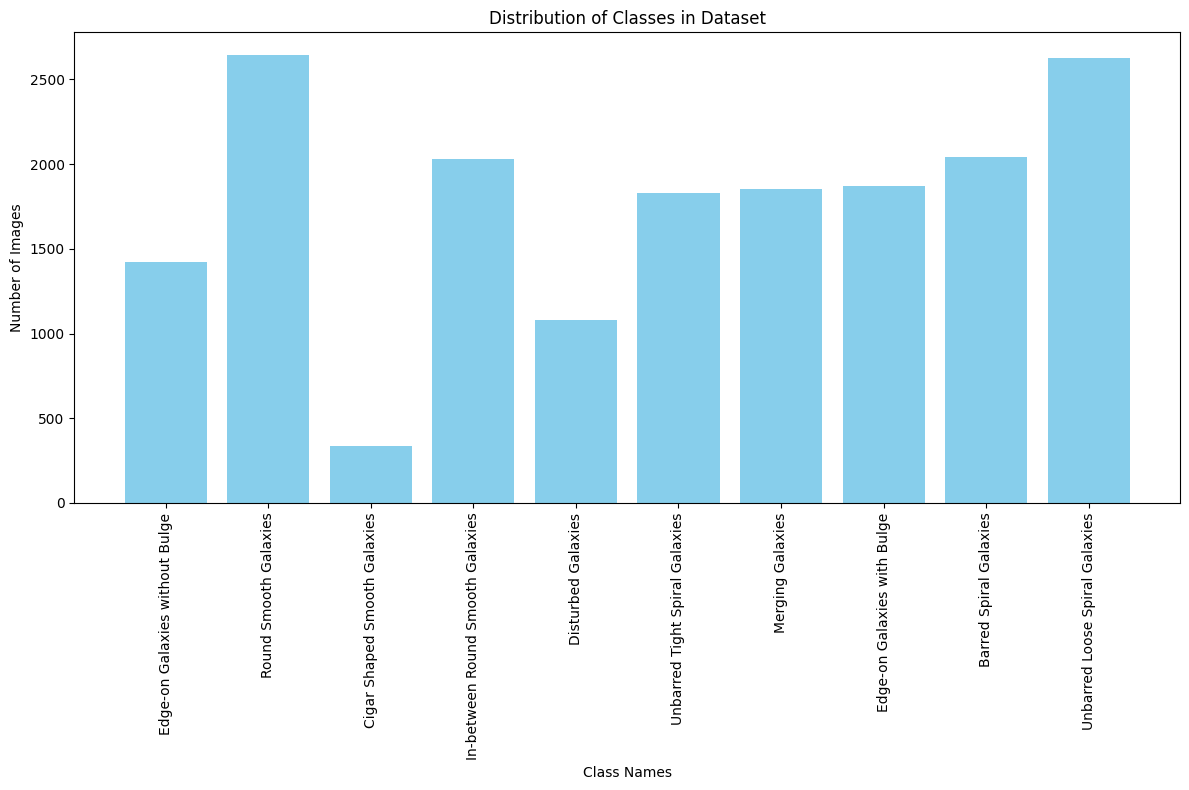

In [5]:
# Histogram of original dataset
import matplotlib.pyplot as plt

dataset_path = 'content/dataset'

class_names = os.listdir(dataset_path)
image_counts = [len(os.listdir(os.path.join(dataset_path, class_name))) for class_name in class_names]

plt.figure(figsize=(12, 8))
plt.bar(class_names, image_counts, color='skyblue')
plt.xlabel('Class Names')
plt.ylabel('Number of Images')
plt.xticks(rotation=90)
plt.title('Distribution of Classes in Dataset')
plt.tight_layout()
plt.show()

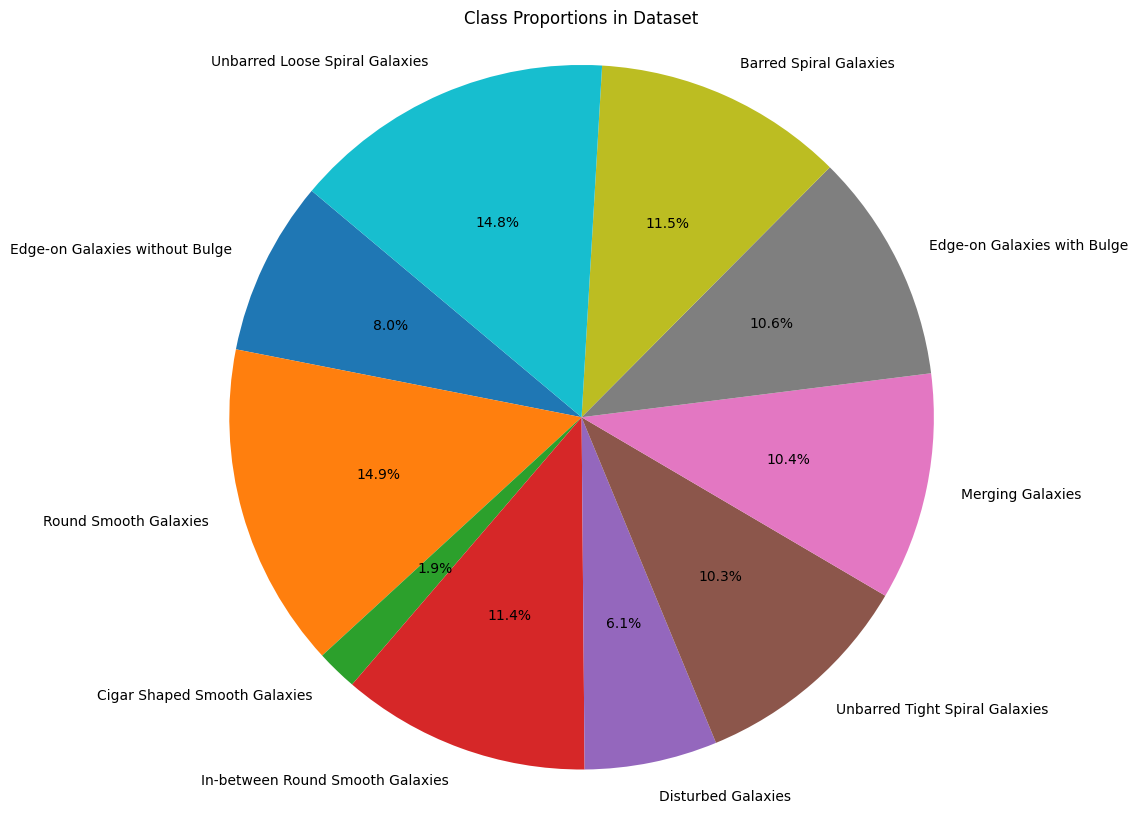

In [6]:
# Pie Chart for original dataset
plt.figure(figsize=(10, 10))
plt.pie(image_counts, labels=class_names, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Class Proportions in Dataset')
plt.show()


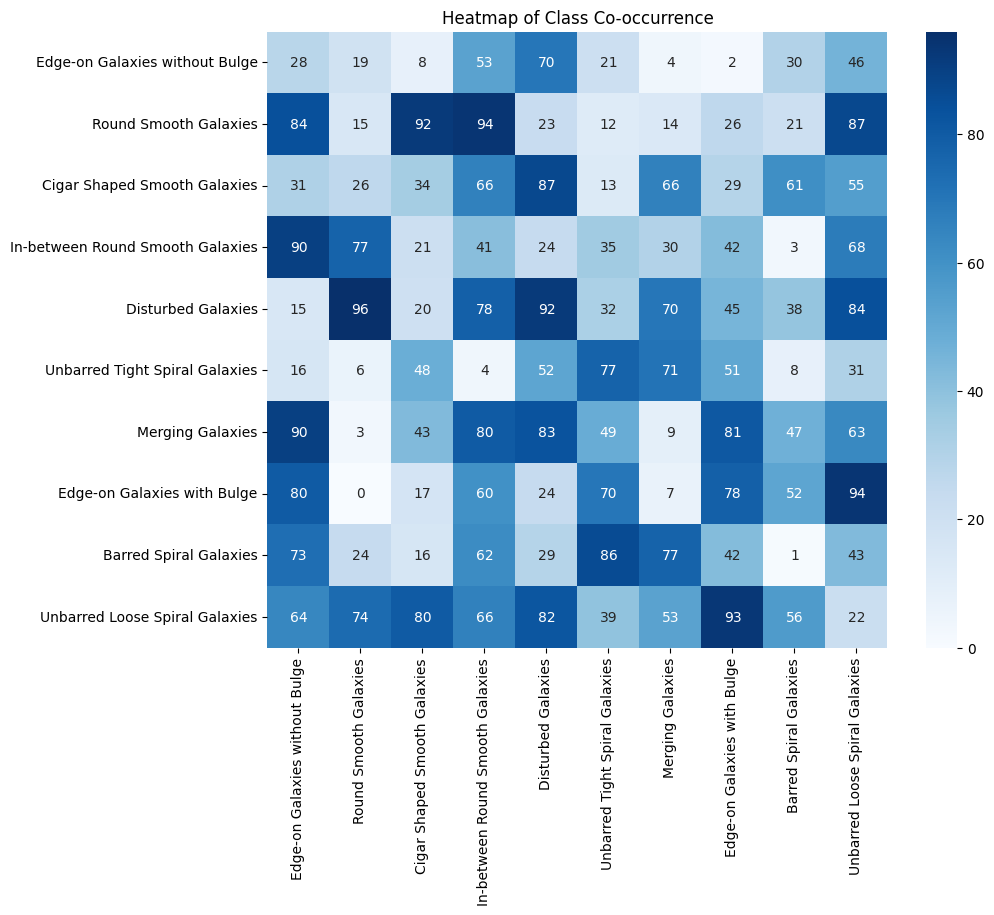

In [7]:
import numpy as np
import seaborn as sns

# Heatmap co-occurrence matrix of original dataset
co_occurrence_matrix = np.random.randint(0, 100, size=(len(class_names), len(class_names)))

plt.figure(figsize=(10, 8))
sns.heatmap(co_occurrence_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Heatmap of Class Co-occurrence')
plt.show()


# 6. Data Augmentation

In [8]:
# Rotating original images of each folder by 90, 180, 270 degrees to increase datasize

from PIL import Image

def rotate_and_save_image(image_path, degrees, save_path):
    with Image.open(image_path) as img:
        rotated_img = img.rotate(degrees, expand=True)
        rotated_img.save(save_path)

def augment_dataset(original_folder):
    for subdir, dirs, files in os.walk(original_folder):
        for file in files:
            file_path = os.path.join(subdir, file)
            for angle in [90, 180, 270]:
                new_file_path = f"{os.path.splitext(file_path)[0]}_{angle}{os.path.splitext(file_path)[1]}"
                rotate_and_save_image(file_path, angle, new_file_path)

# Augment the dataset
augment_dataset('content/dataset')


# 7. Split dataset into training and testing

In [9]:
import shutil
from sklearn.model_selection import train_test_split

def split_data(source_folder, train_folder, test_folder, test_size=0.15):
    for class_name in os.listdir(source_folder):
        class_path = os.path.join(source_folder, class_name)
        images = os.listdir(class_path)

        train_imgs, test_imgs = train_test_split(images, test_size=test_size, random_state=42)

        for img in train_imgs:
            src = os.path.join(class_path, img)
            dst = os.path.join(train_folder, class_name, img)
            os.makedirs(os.path.dirname(dst), exist_ok=True)
            shutil.copy(src, dst)

        for img in test_imgs:
            src = os.path.join(class_path, img)
            dst = os.path.join(test_folder, class_name, img)
            os.makedirs(os.path.dirname(dst), exist_ok=True)
            shutil.copy(src, dst)

split_data('content/dataset', 'content/train', 'content/test')


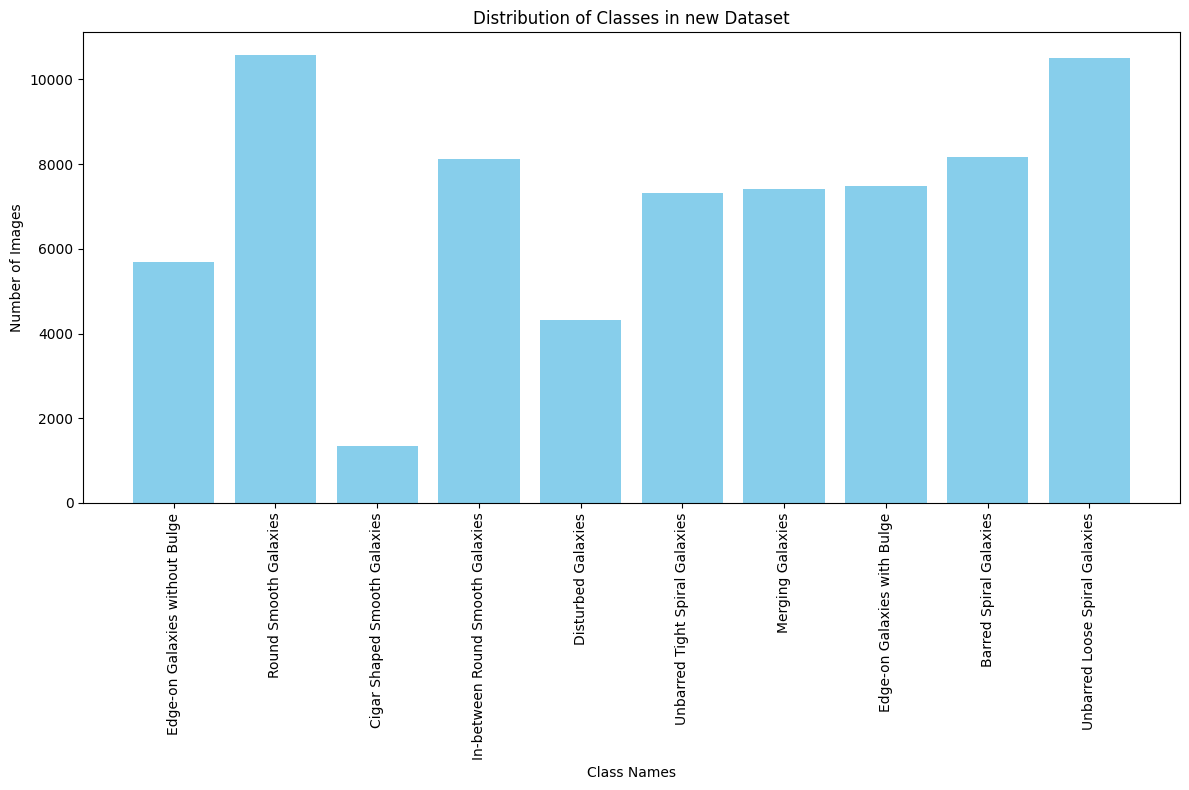

In [10]:
# Histogram of new dataset
import matplotlib.pyplot as plt

dataset_path = 'content/dataset'

class_names = os.listdir(dataset_path)
image_counts = [len(os.listdir(os.path.join(dataset_path, class_name))) for class_name in class_names]

plt.figure(figsize=(12, 8))
plt.bar(class_names, image_counts, color='skyblue')
plt.xlabel('Class Names')
plt.ylabel('Number of Images')
plt.xticks(rotation=90)
plt.title('Distribution of Classes in new Dataset')
plt.tight_layout()
plt.show()

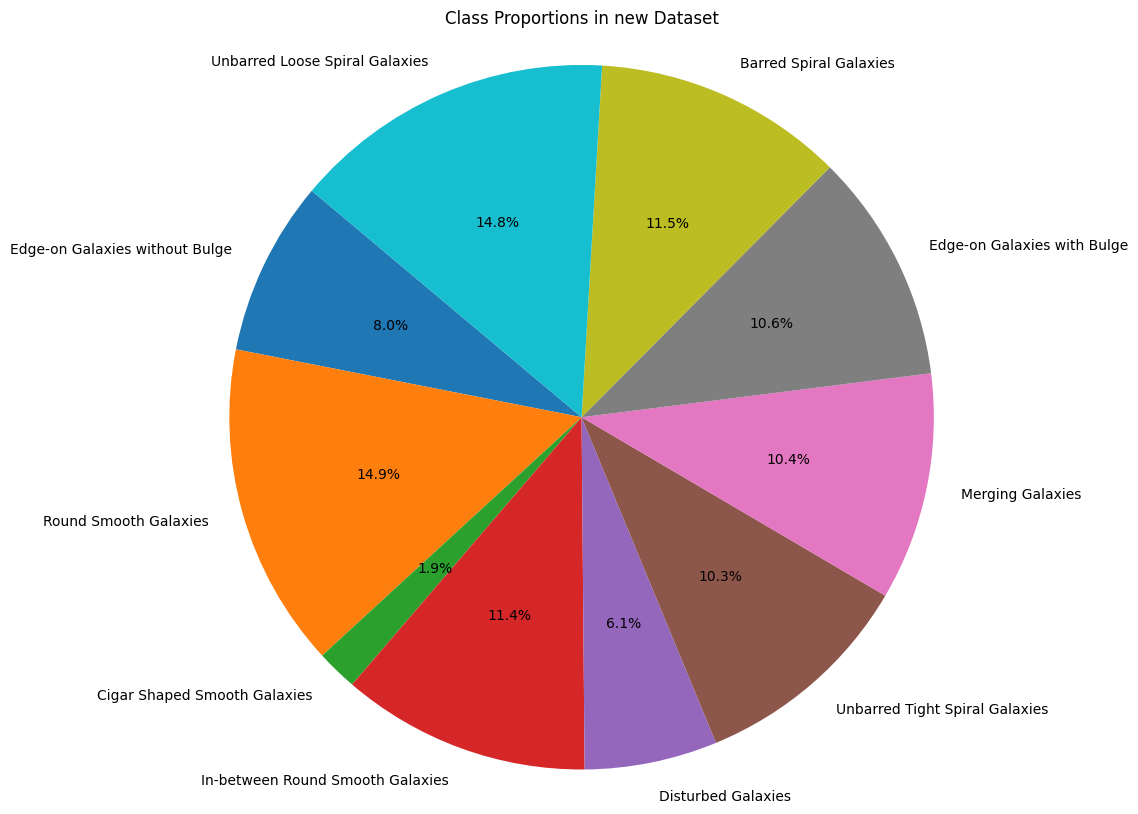

In [11]:
# Pie Chart for new dataset
plt.figure(figsize=(10, 10))
plt.pie(image_counts, labels=class_names, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Class Proportions in new Dataset')
plt.show()


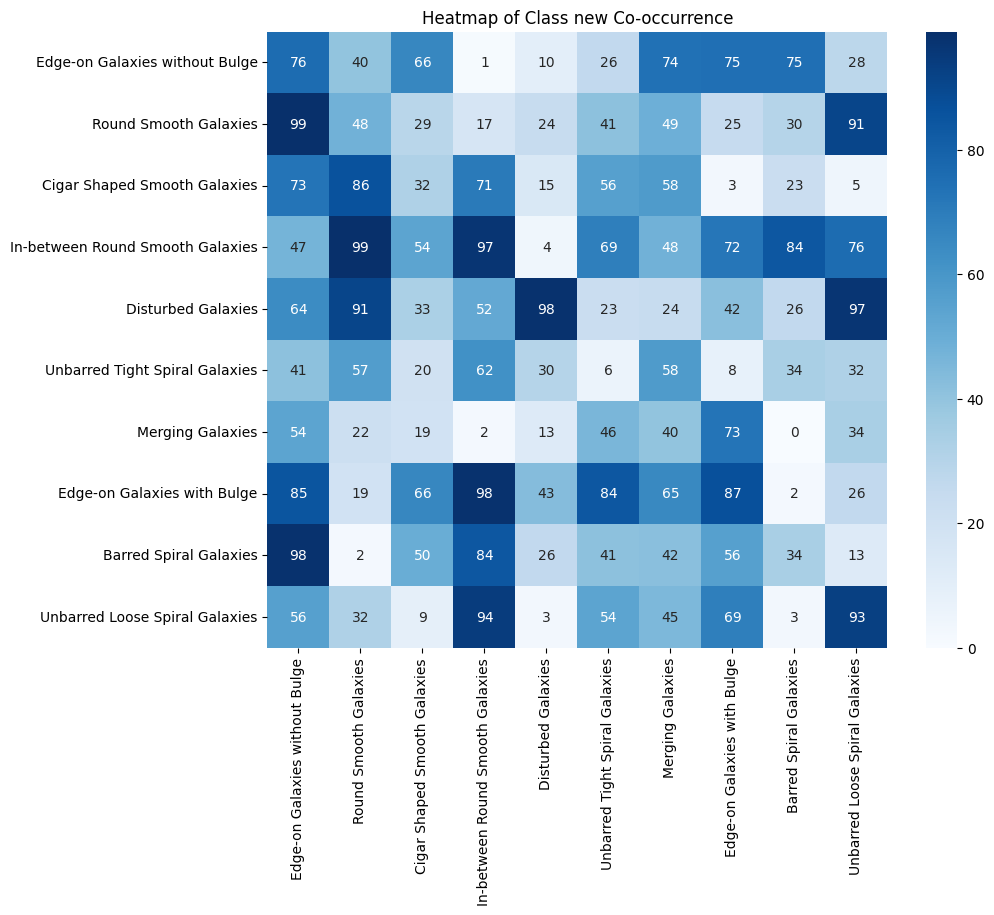

In [12]:
import numpy as np
import seaborn as sns

# Heatmap co-occurrence matrix of new dataset
co_occurrence_matrix = np.random.randint(0, 100, size=(len(class_names), len(class_names)))

plt.figure(figsize=(10, 8))
sns.heatmap(co_occurrence_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Heatmap of Class new Co-occurrence')
plt.show()


# 8. Data Processing

In [13]:
# counting the total number of images from all folders and then each class

import os

def count_images_classes(dataset_path):
    total_images = 0
    classes = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    class_counts = {}

    for class_name in classes:
        class_path = os.path.join(dataset_path, class_name)
        image_count = len([img for img in os.listdir(class_path) if img.endswith(('.png', '.jpg', '.jpeg'))])
        class_counts[class_name] = image_count
        total_images += image_count

    return total_images, len(classes), class_counts

total_images, total_classes, class_counts = count_images_classes(dataset_path)

print(f"Total images found: {total_images}")
print(f"Number of classes: {total_classes}")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")


Total images found: 70944
Number of classes: 10
Edge-on Galaxies without Bulge: 5692 images
Round Smooth Galaxies: 10580 images
Cigar Shaped Smooth Galaxies: 1336 images
In-between Round Smooth Galaxies: 8108 images
Disturbed Galaxies: 4324 images
Unbarred Tight Spiral Galaxies: 7316 images
Merging Galaxies: 7412 images
Edge-on Galaxies with Bulge: 7492 images
Barred Spiral Galaxies: 8172 images
Unbarred Loose Spiral Galaxies: 10512 images


In [14]:
# Counting the total number of images in test and train folders, then each class in those folders

train_dataset_path = 'content/train'  # Adjust as necessary
test_dataset_path = 'content/test'  # Adjust as necessary

# For the training dataset
total_images_train, total_classes_train, class_counts_train = count_images_classes(train_dataset_path)
print(f"Training Dataset: Total images found: {total_images_train}")
print(f"Training Dataset: Number of classes: {total_classes_train}")
for class_name, count in class_counts_train.items():
    print(f"Train - {class_name}: {count} images")

# For the testing dataset
total_images_test, total_classes_test, class_counts_test = count_images_classes(test_dataset_path)
print(f"\nTesting Dataset: Total images found: {total_images_test}")
print(f"Testing Dataset: Number of classes: {total_classes_test}")
for class_name, count in class_counts_test.items():
    print(f"Test - {class_name}: {count} images")


Training Dataset: Total images found: 60299
Training Dataset: Number of classes: 10
Train - Edge-on Galaxies without Bulge: 4838 images
Train - Round Smooth Galaxies: 8993 images
Train - Cigar Shaped Smooth Galaxies: 1135 images
Train - In-between Round Smooth Galaxies: 6891 images
Train - Disturbed Galaxies: 3675 images
Train - Unbarred Tight Spiral Galaxies: 6218 images
Train - Merging Galaxies: 6300 images
Train - Edge-on Galaxies with Bulge: 6368 images
Train - Barred Spiral Galaxies: 6946 images
Train - Unbarred Loose Spiral Galaxies: 8935 images

Testing Dataset: Total images found: 10645
Testing Dataset: Number of classes: 10
Test - Edge-on Galaxies without Bulge: 854 images
Test - Round Smooth Galaxies: 1587 images
Test - Cigar Shaped Smooth Galaxies: 201 images
Test - In-between Round Smooth Galaxies: 1217 images
Test - Disturbed Galaxies: 649 images
Test - Unbarred Tight Spiral Galaxies: 1098 images
Test - Merging Galaxies: 1112 images
Test - Edge-on Galaxies with Bulge: 1124

# 9. Data Visualization after data augmentation

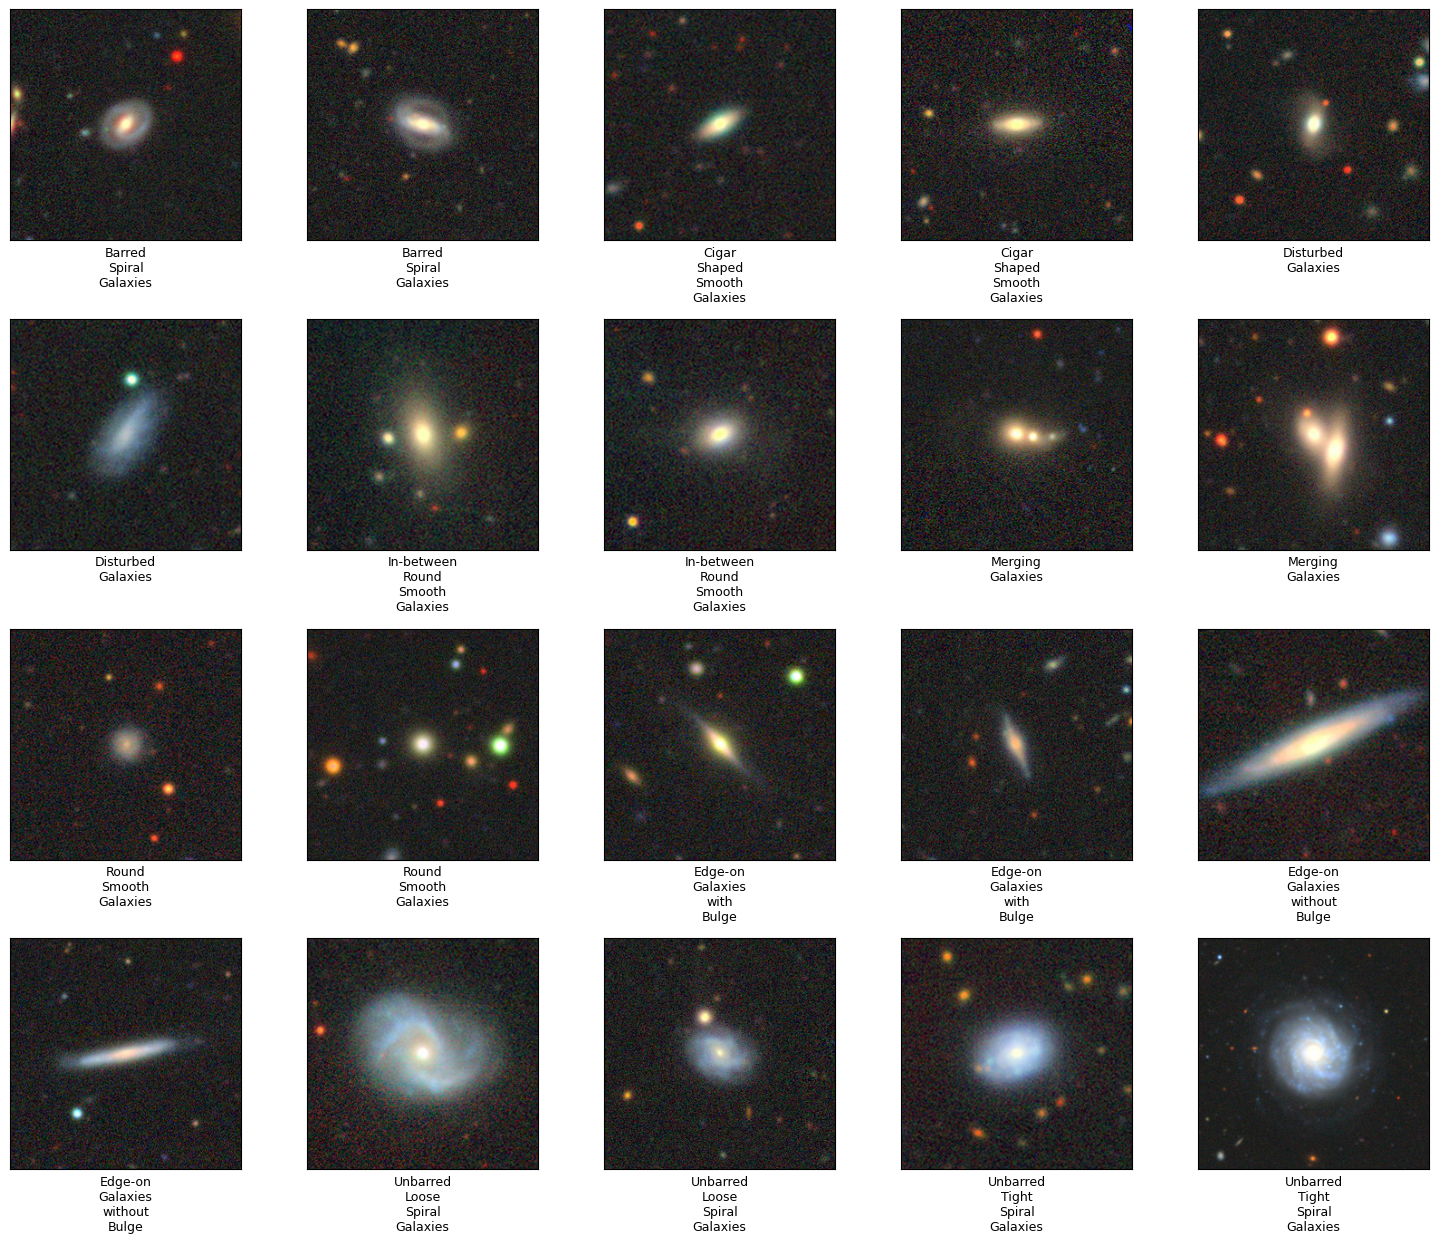

In [15]:
# Displaying random class images
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
import os

# class names
class_names = ['Barred Spiral Galaxies', 'Cigar Shaped Smooth Galaxies', 'Disturbed Galaxies', 'In-between Round Smooth Galaxies',
               'Merging Galaxies', 'Round Smooth Galaxies', 'Edge-on Galaxies with Bulge', 'Edge-on Galaxies without Bulge',
               'Unbarred Loose Spiral Galaxies', 'Unbarred Tight Spiral Galaxies']

train_folder = 'content/train'

def load_sample_images(train_folder, class_names, samples_per_class=2):
    images, labels = [], []
    for class_name in class_names:
        class_path = os.path.join(train_folder, class_name)
        img_files = os.listdir(class_path)[:samples_per_class]
        for img_file in img_files:
            img_path = os.path.join(class_path, img_file)
            images.append(load_img(img_path, target_size=(256, 256)))
            labels.append(class_name)
    return images, labels

images, labels = load_sample_images(train_folder, class_names)

# Calculate grid size
total_images = len(images)
grid_size = int(total_images ** 0.5) + 1  # Square root of total_images, rounded up

plt.figure(figsize=(15, 15))  # Increased figure size for better visibility
for i, (image, label) in enumerate(zip(images, labels)):
    if i < grid_size**2:  # Ensure we do not exceed grid size
        ax = plt.subplot(grid_size, grid_size, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image)
        label = '\n'.join(label.split())  # Split long labels into multiple lines
        plt.xlabel(label, fontsize=9)
plt.tight_layout()
plt.show()


In [16]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.3 MB/s eta 0:00:00


# 10. Building the CNN model

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.4),  # Adjusted dropout rate
    Dense(10, activation='softmax')
])


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Setting up the ImageDataGenerator for the training data with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,  # Increased rotation range
    width_shift_range=0.25,  # Slightly increased shift ranges
    height_shift_range=0.25,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,  # Added vertical flip
    fill_mode='nearest'
)


# Setting up the ImageDataGenerator for the test data without augmentation, only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# Creating the training data generator
train_generator = train_datagen.flow_from_directory(
    'content/train',
    target_size=(128, 128) ,
    batch_size=32,
    class_mode='categorical'
)

# Creating the test data generator
test_generator = test_datagen.flow_from_directory(
    'content/test',
    target_size=(128, 128) ,
    batch_size=32,
    class_mode='categorical'
)


Found 60299 images belonging to 10 classes.
Found 10645 images belonging to 10 classes.


In [19]:
# Train the model
history = model.fit(train_generator, epochs=10, validation_data=test_generator)

Epoch 1/10
1885/1885 [==============================] - 417s 218ms/step - loss: 1.4831 - accuracy: 0.4628 - val_loss: 1.4899 - val_accuracy: 0.4707
Epoch 2/10
1885/1885 [==============================] - 411s 218ms/step - loss: 1.0321 - accuracy: 0.6374 - val_loss: 1.1583 - val_accuracy: 0.5876
Epoch 3/10
1885/1885 [==============================] - 416s 221ms/step - loss: 0.9147 - accuracy: 0.6830 - val_loss: 1.0558 - val_accuracy: 0.6211
Epoch 4/10
1885/1885 [==============================] - 411s 218ms/step - loss: 0.8498 - accuracy: 0.7064 - val_loss: 1.2383 - val_accuracy: 0.5964
Epoch 5/10
1885/1885 [==============================] - 414s 220ms/step - loss: 0.8036 - accuracy: 0.7203 - val_loss: 1.1356 - val_accuracy: 0.6367
Epoch 6/10
1885/1885 [==============================] - 412s 219ms/step - loss: 0.7818 - accuracy: 0.7293 - val_loss: 0.7808 - val_accuracy: 0.7284
Epoch 7/10
1885/1885 [==============================] - 414s 220ms/step - loss: 0.7558 - accuracy: 0.7376 - val_

# 11. Plot Performance

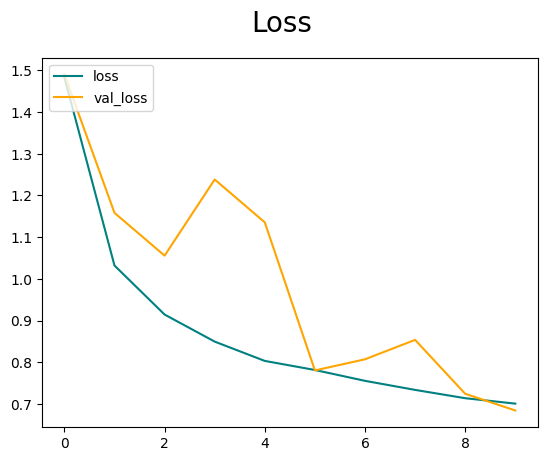

In [20]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

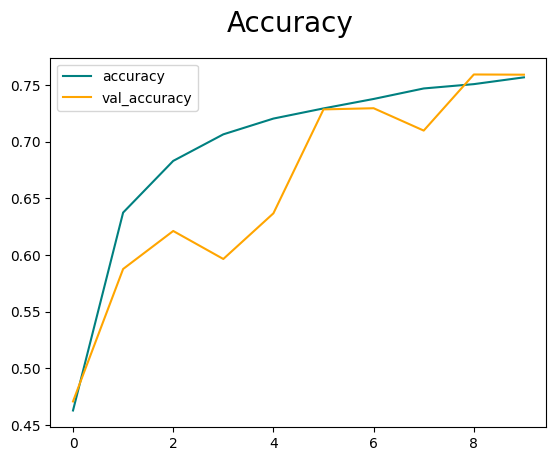

In [21]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 12. Evaluate

In [22]:
# Evaluate the model
eval_result = model.evaluate(test_generator)
print(f"Test Loss: {eval_result[0]}, Test Accuracy: {eval_result[1]}")


333/333 [==============================] - 33s 100ms/step - loss: 0.6848 - accuracy: 0.7590
Test Loss: 0.6848068237304688, Test Accuracy: 0.7590417861938477


# 13. Test

1/1 [==============================] - 0s 16ms/step


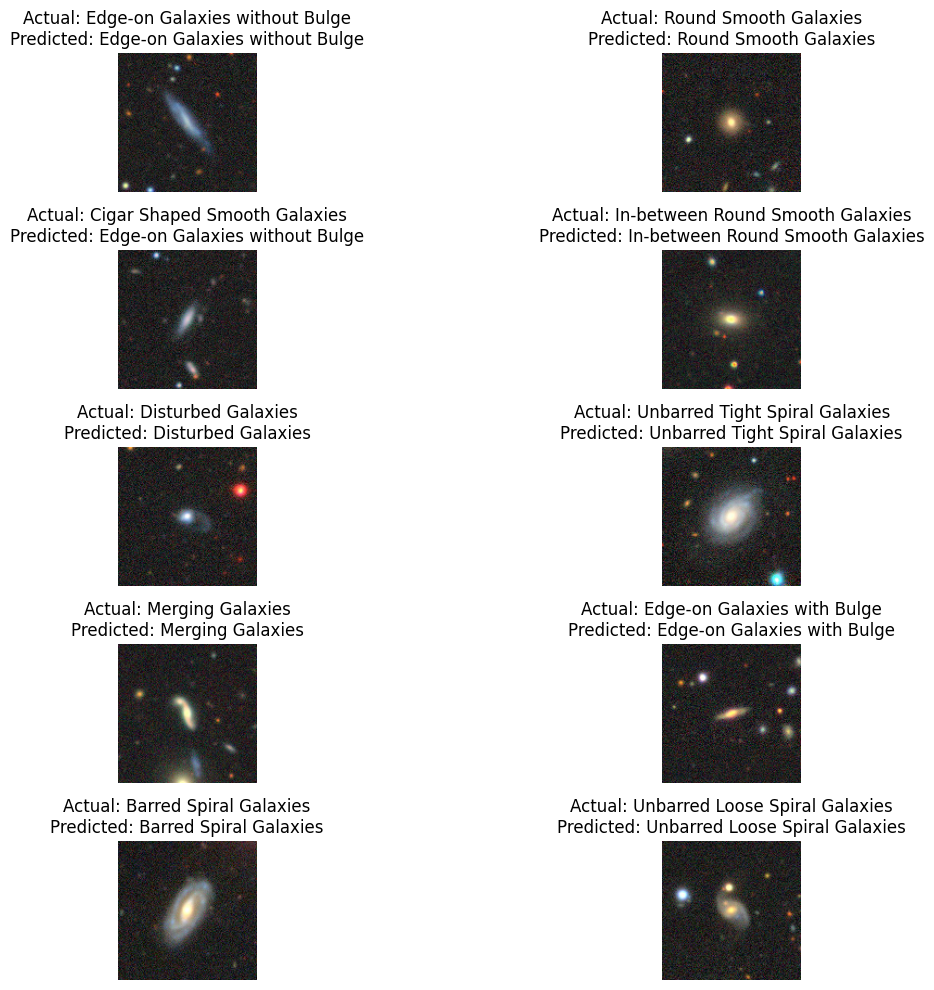

In [23]:
import random
from tensorflow.keras.preprocessing.image import img_to_array

# test dataset directory path
test_dataset_path = 'content/test'

# Create a dictionary to map class indices to class names for the test data
index_to_class = {test_generator.class_indices[class_name]: class_name for class_name in test_generator.class_indices}

# Create a dictionary to store one random image path for each class
random_images_per_class = {}
for class_name in os.listdir(test_dataset_path):
    class_dir = os.path.join(test_dataset_path, class_name)
    if os.path.isdir(class_dir):
        images = os.listdir(class_dir)
        if images:
            random_image = random.choice(images)
            random_images_per_class[class_name] = os.path.join(class_dir, random_image)

# Display and predict the randomly selected images
plt.figure(figsize=(15, 10))
for i, (class_name, img_path) in enumerate(random_images_per_class.items()):
    # Load the image with a target size of 128x128 pixels
    img = load_img(img_path, target_size=(128, 128))
    img_array = img_to_array(img) / 255.0
    img_array_expanded = np.expand_dims(img_array, axis=0)  # Expand dims to match the model's input shape
    prediction = model.predict(img_array_expanded)
    predicted_class = index_to_class[prediction.argmax(axis=-1)[0]]

    plt.subplot(5, 2, i+1)
    plt.imshow(img_array)
    plt.title(f"Actual: {class_name}\nPredicted: {predicted_class}")
    plt.axis('off')

plt.tight_layout()
plt.show()


# 14. Save the Model

In [24]:
model_save_path = '/content/drive/My Drive/model10'  # path in Google Drive
model.save(model_save_path)


In [25]:
model_save_path = '/content/drive/My Drive/model10.h5'  # path and file name in Google Drive
model.save(model_save_path, save_format='h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
